In [1]:
!git clone https://github.com/Bore237/TrOCR-Fine-Tuning-on-Curved-Scene-Text

Cloning into 'TrOCR-Fine-Tuning-on-Curved-Scene-Text'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 122 (delta 56), reused 111 (delta 45), pack-reused 0 (from 0)
Receiving objects: 100% (122/122), 18.06 KiB | 3.01 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [2]:
%cd TrOCR-Fine-Tuning-on-Curved-Scene-Text
!ls

/kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text
configs  notebooks  README.md  requirements.txt  src


In [3]:
!pip install -q evaluate
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 69.8 MB/s eta 0:00:00:00:01


In [21]:
# Dataset import
from torch.utils.data import DataLoader
from src import SCUTDataset
from PIL import Image

# Model import
from src import load_model
from dataclasses import dataclass
from torchvision import transforms
import yaml

# Trainning import
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import evaluate
from tqdm import tqdm
from torch.amp import autocast

# Log and visualisation
from src import MetricLogger
import matplotlib.pyplot as plt

In [5]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 16
    EPOCHS:        int = 25
    LEARNING_RATE: float = 0.000005

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = 'captcha_data'

@dataclass(frozen=True)
class ModelConfig:
    """
    Check this for complete pretrained Transformer Configuration.
    https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/configuration#transformers.PretrainedConfig
    """
    MODEL_NAME: str = 'microsoft/trocr-small-handwritten'

In [6]:
train_dir = "/kaggle/input/datasets/borelgoudjou/scut-ctw1500/scut_data/scut_train/"
train_ann = "/kaggle/input/datasets/borelgoudjou/scut-ctw1500/scut_data/scut_train.txt"
val_dir   = "/kaggle/input/datasets/borelgoudjou/scut-ctw1500/scut_data/scut_test/"
val_ann   = "/kaggle/input/datasets/borelgoudjou/scut-ctw1500/scut_data/scut_test.txt"
config_path = "/kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text/configs/config.yaml"

In [7]:
torch.backends.cudnn.benchmark = True

In [8]:
#def main():

# ----------------------------- # Charger config.yaml # -----------------------------
with open(config_path, "r") as f: 
    config = yaml.safe_load(f)

# ----------------------------- # Charger modèle + processor # -----------------------------
processor, model, device = load_model(model_name = config["model"]['name'], verbose = True) #'microsoft/trocr-small-printed'

# ----------------------------- # Charger datasets # -----------------------------
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

train_dataset = SCUTDataset(
    root_dir=config["data"]["train_path"],    
    ann_path= config["data"]["train_ann"],
    processor= processor,
    train_transforms = train_transforms
)

val_dataset = SCUTDataset(
    root_dir=config["data"]["val_path"],     
    ann_path= config["data"]["val_ann"],
    processor= processor,
    train_transforms = None
)

# ----------------------------- # DataLoaders # -----------------------------
train_dataloader = DataLoader(
    train_dataset, 
    batch_size= 32, #config["dataloader"]["train_batch_size"], 
    shuffle=config["dataloader"]["shuffle"],
    num_workers=config["dataloader"]["num_workers"],
    pin_memory=True,
    persistent_workers=True
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size= 32, #config["dataloader"]["val_batch_size"], 
    shuffle=False,
    num_workers=config["dataloader"]["num_workers"],
    pin_memory=True,
    persistent_workers=True
)

preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

61,596,672 total parameters.
61,596,672 training parameters.


In [9]:
# ----------------------------- # Optimizer + Scheduler # -----------------------------

if config["model"]["freeze_encoder"]:
    for param in model.encoder.parameters():
            param.requires_grad = False

# Create optimizer only on trainable params
optimizer = AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=float(config["optimizer"]["lr_freeze"]),
    weight_decay=config["optimizer"]["weight_decay"],
    fused=True,
)

num_epochs = config["training"]["num_epochs"]
num_training_steps = num_epochs * len(train_dataloader)
scheduler = None
if config["training"]["num_epochs"]:
    scheduler = get_linear_schedule_with_warmup( optimizer, 
                                            num_warmup_steps=int(config["scheduler"]["warmup_ratio"] * num_training_steps), 
                                            num_training_steps=num_training_steps )

# ----------------------------- # AMP Scaler # -----------------------------
scaler = torch.amp.GradScaler(enabled=config["training"]["mixed_precision"])

# ----------------------------- # Metrics # -----------------------------
wer_metric = evaluate.load("wer") 
cer_metric = evaluate.load("cer")

logger = MetricLogger(save_dir=config["visualization"]["plot_dir"])

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

## Train.utils

In [10]:
def compute_ocr_metric(processor, pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
     # Clone pour éviter modification en place
    label_ids = label_ids.clone()
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)
    
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    return cer, wer

In [11]:
def train_scale_one_epoch(model, processor, train_dataloader, optimizer, scheduler, device, scaler):
    model.train()
    torch.set_grad_enabled(True)
    total_loss = 0
    all_wers = 0.0
    all_cers = 0.0

    for batch in tqdm(train_dataloader, desc="Training"):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Forward en mixed precision
        with autocast(device, enabled=config["training"]["mixed_precision"]):
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        
        if scheduler:
            scheduler.step()

        total_loss += loss.item()

        with torch.no_grad():
            pred_ids = model.generate(pixel_values=pixel_values)
            cer, wer = compute_ocr_metric(processor, pred_ids, labels)
            all_wers += wer
            all_cers += cer

    return {
            "loss": total_loss / len(train_dataloader),
            "cer": all_cers / len(train_dataloader),
            "wer": all_wers / len(train_dataloader)
           }

In [12]:
def evaluate_one_epoch(model, processor, val_loader, device):
    model.eval()
    all_wers = 0.0
    all_cers = 0.0
    
    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch["pixel_values"].to(device)
            label_ids = batch["labels"].to(device)

            # Génération
            pred_ids = model.generate(pixel_values)

            # Calcul CER/WER
            cer, wer = compute_ocr_metric(processor, pred_ids, label_ids)
            all_wers += wer
            all_cers += cer


    return {"wer": all_wers / len(val_loader), "cer": all_cers / len(val_loader) }

In [13]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, mode="min", save_path=None):
        """
        Args:
            patience (int): epochs to wait before stopping
            min_delta (float): minimum improvement required
            mode (str): "min" or "max"
            save_path (str): path to save best model
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.save_path = save_path

        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, metric, model,  epoch, optimizer):

        if self.best_score is None:
            self.best_score = metric
            self._save_model(model, epoch, optimizer)
            return

        improvement = (
            metric < self.best_score - self.min_delta
            if self.mode == "min"
            else metric > self.best_score + self.min_delta
        )

        if improvement:
            self.best_score = metric
            self.counter = 0
            self._save_model(model, epoch, optimizer)
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter}/{self.patience}")

            if self.counter >= self.patience:
                self.early_stop = True

    def _save_model(self, model, epoch, optimizer):
        if self.save_path and model is not None:
            checkpoint = {
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "epoch": epoch
            }
            torch.save(checkpoint, self.save_path)


In [50]:
def load_checkpoint(model, optimizer, scheduler, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
    return checkpoint["epoch"]


In [14]:
early_stopping = EarlyStopping(
    patience=12,
    min_delta=0.005,
    mode="min",
    save_path="best_model.pth"
)

In [15]:
# ----------------------------- # Training Loop # -----------------------------
for epoch in range(num_epochs):
    print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")
    
    if epoch == 4:# config["model"]["unfreeze_epoch"]:
        print("Unfreezing encoder...")
        for param in model.encoder.parameters():
            param.requires_grad = True
    
        optimizer = AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=float(config["optimizer"]["lr_unfreeze"]),
            weight_decay=0.001, #0.01
            fused=True
        )
    
    train_out  = train_scale_one_epoch(model, processor, train_dataloader, optimizer, scheduler, device, scaler)
    print(f"Epoch {epoch} - Loss: {train_out["loss"]:.4f} - Cer: {train_out["cer"]:.4f}")
    
    val_metrics  = evaluate_one_epoch(model, processor, val_dataloader, device) 
    print(f"Validation — WER: {val_metrics ['wer']:.4f}, CER: {val_metrics ['cer']:.4f}")

    # Log metrics 
    logger.log( train_loss=train_out["loss"], val_wer=val_metrics["wer"], val_cer=val_metrics["cer"] )
    
    #Save the best model
    early_stopping(val_metrics['cer'], model, epoch, optimizer)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break


===== Epoch 1/30 =====


Training: 100%|██████████| 190/190 [02:44<00:00,  1.15it/s]

Epoch 0 - Loss: 7.7556 - Cer: 1.0741


Validation — WER: 1.0323, CER: 0.9936

===== Epoch 2/30 =====


Training: 100%|██████████| 190/190 [02:32<00:00,  1.24it/s]


Epoch 1 - Loss: 6.5057 - Cer: 0.9677
Validation — WER: 0.9819, CER: 0.9592

===== Epoch 3/30 =====


Training: 100%|██████████| 190/190 [02:19<00:00,  1.37it/s]


Epoch 2 - Loss: 6.0722 - Cer: 0.9648
Validation — WER: 0.9876, CER: 0.9455

===== Epoch 4/30 =====


Training: 100%|██████████| 190/190 [02:18<00:00,  1.37it/s]


Epoch 3 - Loss: 5.8165 - Cer: 0.9691
Validation — WER: 0.9900, CER: 0.9470
EarlyStopping counter: 1/12

===== Epoch 5/30 =====
Unfreezing encoder...


Training: 100%|██████████| 190/190 [03:45<00:00,  1.19s/it]


Epoch 4 - Loss: 5.6152 - Cer: 0.9525
Validation — WER: 0.9843, CER: 0.9101

===== Epoch 6/30 =====


Training: 100%|██████████| 190/190 [03:53<00:00,  1.23s/it]


Epoch 5 - Loss: 5.1564 - Cer: 0.8882
Validation — WER: 0.9662, CER: 0.8914

===== Epoch 7/30 =====


Training: 100%|██████████| 190/190 [03:55<00:00,  1.24s/it]


Epoch 6 - Loss: 4.6959 - Cer: 0.8169
Validation — WER: 0.9546, CER: 0.8110

===== Epoch 8/30 =====


Training: 100%|██████████| 190/190 [03:49<00:00,  1.21s/it]


Epoch 7 - Loss: 4.3363 - Cer: 0.7667
Validation — WER: 0.9509, CER: 0.7536

===== Epoch 9/30 =====


Training: 100%|██████████| 190/190 [03:47<00:00,  1.20s/it]


Epoch 8 - Loss: 4.0224 - Cer: 0.7206
Validation — WER: 0.9469, CER: 0.7388

===== Epoch 10/30 =====


Training: 100%|██████████| 190/190 [03:48<00:00,  1.20s/it]


Epoch 9 - Loss: 3.7319 - Cer: 0.6859
Validation — WER: 0.9293, CER: 0.7266

===== Epoch 11/30 =====


Training: 100%|██████████| 190/190 [03:51<00:00,  1.22s/it]


Epoch 10 - Loss: 3.4781 - Cer: 0.6730
Validation — WER: 0.9405, CER: 0.7040

===== Epoch 12/30 =====


Training: 100%|██████████| 190/190 [03:47<00:00,  1.20s/it]


Epoch 11 - Loss: 3.3104 - Cer: 0.6510
Validation — WER: 0.9355, CER: 0.7004
EarlyStopping counter: 1/12

===== Epoch 13/30 =====


Training: 100%|██████████| 190/190 [03:46<00:00,  1.19s/it]


Epoch 12 - Loss: 3.1121 - Cer: 0.6291
Validation — WER: 0.9264, CER: 0.6941

===== Epoch 14/30 =====


Training: 100%|██████████| 190/190 [03:49<00:00,  1.21s/it]


Epoch 13 - Loss: 2.9663 - Cer: 0.6186
Validation — WER: 0.9201, CER: 0.6815

===== Epoch 15/30 =====


Training: 100%|██████████| 190/190 [03:51<00:00,  1.22s/it]


Epoch 14 - Loss: 2.8484 - Cer: 0.6055
Validation — WER: 0.9189, CER: 0.6860
EarlyStopping counter: 1/12

===== Epoch 16/30 =====


Training: 100%|██████████| 190/190 [03:50<00:00,  1.21s/it]


Epoch 15 - Loss: 2.6860 - Cer: 0.5957
Validation — WER: 0.9126, CER: 0.7087
EarlyStopping counter: 2/12

===== Epoch 17/30 =====


Training: 100%|██████████| 190/190 [03:51<00:00,  1.22s/it]


Epoch 16 - Loss: 2.6049 - Cer: 0.6037
Validation — WER: 0.9148, CER: 0.6954
EarlyStopping counter: 3/12

===== Epoch 18/30 =====


Training: 100%|██████████| 190/190 [03:48<00:00,  1.20s/it]


Epoch 17 - Loss: 2.4643 - Cer: 0.5900
Validation — WER: 0.9291, CER: 0.6815
EarlyStopping counter: 4/12

===== Epoch 19/30 =====


Training: 100%|██████████| 190/190 [03:48<00:00,  1.20s/it]


Epoch 18 - Loss: 2.3409 - Cer: 0.5742
Validation — WER: 0.9356, CER: 0.6891
EarlyStopping counter: 5/12

===== Epoch 20/30 =====


Training: 100%|██████████| 190/190 [03:50<00:00,  1.21s/it]


Epoch 19 - Loss: 2.2086 - Cer: 0.5666
Validation — WER: 0.9251, CER: 0.6727

===== Epoch 21/30 =====


Training: 100%|██████████| 190/190 [03:50<00:00,  1.21s/it]


Epoch 20 - Loss: 2.1457 - Cer: 0.5630
Validation — WER: 0.9268, CER: 0.6631

===== Epoch 22/30 =====


Training: 100%|██████████| 190/190 [03:48<00:00,  1.21s/it]


Epoch 21 - Loss: 2.0936 - Cer: 0.5634
Validation — WER: 0.9174, CER: 0.6599
EarlyStopping counter: 1/12

===== Epoch 23/30 =====


Training: 100%|██████████| 190/190 [03:49<00:00,  1.21s/it]


Epoch 22 - Loss: 1.9409 - Cer: 0.5397
Validation — WER: 0.9236, CER: 0.6636
EarlyStopping counter: 2/12

===== Epoch 24/30 =====


Training: 100%|██████████| 190/190 [03:50<00:00,  1.21s/it]


Epoch 23 - Loss: 1.8754 - Cer: 0.5328
Validation — WER: 0.9214, CER: 0.6457

===== Epoch 25/30 =====


Training: 100%|██████████| 190/190 [03:49<00:00,  1.21s/it]


Epoch 24 - Loss: 1.8099 - Cer: 0.5316
Validation — WER: 0.9205, CER: 0.6431
EarlyStopping counter: 1/12

===== Epoch 26/30 =====


Training: 100%|██████████| 190/190 [03:48<00:00,  1.20s/it]


Epoch 25 - Loss: 1.6895 - Cer: 0.5237
Validation — WER: 0.9093, CER: 0.6341

===== Epoch 27/30 =====


Training: 100%|██████████| 190/190 [03:47<00:00,  1.20s/it]


Epoch 26 - Loss: 1.6481 - Cer: 0.5199
Validation — WER: 0.9091, CER: 0.6644
EarlyStopping counter: 1/12

===== Epoch 28/30 =====


Training: 100%|██████████| 190/190 [03:50<00:00,  1.21s/it]


Epoch 27 - Loss: 1.5883 - Cer: 0.5242
Validation — WER: 0.9140, CER: 0.6699
EarlyStopping counter: 2/12

===== Epoch 29/30 =====


Training: 100%|██████████| 190/190 [03:51<00:00,  1.22s/it]


Epoch 28 - Loss: 1.5106 - Cer: 0.5151
Validation — WER: 0.9264, CER: 0.6516
EarlyStopping counter: 3/12

===== Epoch 30/30 =====


Training: 100%|██████████| 190/190 [03:46<00:00,  1.19s/it]


Epoch 29 - Loss: 1.4606 - Cer: 0.5070
Validation — WER: 0.9019, CER: 0.6527
EarlyStopping counter: 4/12


In [31]:
# ----------------------------- # Générer les courbes # -----------------------------
if config["visualization"]["enable"]: 
    pass
logger.plot(metrics_to_plot=config["visualization"]["metrics_to_plot"])

plot_val_cer = Image.open("/kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text/plots/val_wer.png")
plot_val_loss = Image.open("/kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text/plots/train_loss.png")

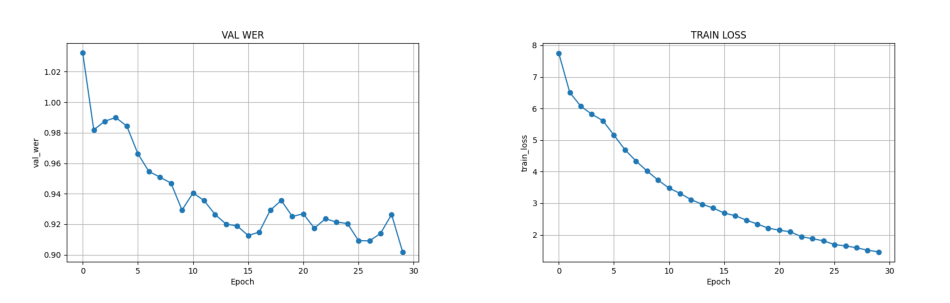

In [48]:
import numpy as np

fig = plt.figure(figsize=(12,10))

plt.subplot(1,2,1)
plt.imshow(np.array(plot_val_cer))
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(np.array(plot_val_loss))
plt.axis("off")

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [49]:
!zip -r TrOCR-Fine-Tuning-on-Curved-Scene-Text.zip /kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text

  adding: kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text/ (stored 0%)
  adding: kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text/src/ (stored 0%)
  adding: kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text/src/visualization.py (deflated 63%)
  adding: kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text/src/utils/ (stored 0%)
  adding: kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text/src/utils/train_utils.py (deflated 57%)
  adding: kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text/src/train.py (stored 0%)
  adding: kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text/src/__init__.py (deflated 25%)
  adding: kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text/src/__pycache__/ (stored 0%)
  adding: kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text/src/__pycache__/dataset.cpython-312.pyc (deflated 41%)
  adding: kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text/src/__pycache__/visualization.cpython-312.pyc (deflated 46%)
  adding: kaggle/working/TrOCR

In [ ]:
from IPython.display import FileLink

# Chemin du fichier zip
zip_path = "/kaggle/working/TrOCR-Fine-Tuning-on-Curved-Scene-Text.zip"

# Affiche un lien de téléchargement
FileLink(zip_path)